# eq_SST_bias: Zonal structure of time-mean SST in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of equatorial Pacific (150°E-90°W) climatological (time and meridional 5°S-5°N average) sea surface temperature (SST) between model and observations

## Observations and reanalysis datasets used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **TropFlux (1979-2018)**: The primary dataset for comparison. TropFlux provides estimates of surface fluxes, including heat, momentum, and freshwater exchanges over the tropical oceans, specifically designed for tropical climate studies, and integrates satellite and in-situ observations.

Additional observational datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data based on surface pressure observations and ensemble assimilation techniques, reconstructing weather patterns over the past 140 years.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), offering high-resolution atmospheric and surface variables using a global assimilation model.
- **ERSSTv5 (1854-2018)**: The Extended Reconstructed Sea Surface Temperature dataset provides monthly global sea surface temperature anomalies based on historical in-situ and satellite observations, widely used in ocean and climate studies.
- **HadISST (1870-2018)**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset offers global monthly SST and sea ice concentration fields, incorporating in-situ and satellite data for climate variability analysis.
- **NCEP2 (1979-2018)**: The second version of the NCEP reanalysis provides a range of atmospheric variables, including surface and upper-air data, and corrects issues in the original dataset, making it suitable for long-term climate and weather assessments.

## Dask Cluster 

Start a cluster with multiple cores 

In [60]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41127 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36505
INFO:distributed.scheduler:  dashboard at:        /proxy/41127/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40519'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43441'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45427'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33081'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40871'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34505'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39345 name:

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41127/status,
Dashboard: /proxy/41127/status,Workers: 6
Total threads: 24,Total memory: 191.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36505,Workers: 0
Dashboard: /proxy/41127/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39345,Total threads: 4
Dashboard: /proxy/45635/status,Memory: 31.83 GiB
Nanny: tcp://127.0.0.1:40519,


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

## Datasets

In [61]:
from esmvalcore.dataset import Dataset

In [62]:
model_datasets = {
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='ts',
#     project='CMIP6',
#     mip="Amon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# ),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [63]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")

In [64]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [65]:
model_datasets['ACCESS-ESM1-5'].dim_coords[2]

<DimCoord: cell index along first dimension / (1)  [ 0, 1, ..., 358, 359]  shape(360,)>

In [66]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [67]:
def prepoc1(cube):
    nino3_ep_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = extract_region(cube, **nino3_ep_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 140., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land") #uses shapefiles, ancVariable, land_area_fraction
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = extract_region(cube, **nino3_latext_region)
    return cube

In [68]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

In [69]:
model_datasets_prep2

{'ACCESS-ESM1-5': <iris 'Cube' of sea_surface_temperature / (degC) (latitude: 30; longitude: 130)>}

In [70]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [71]:
model_data = model_datasets_prep2["ACCESS-ESM1-5"].data

In [72]:
# lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
# lv.rotation(15.0, -150.0, 0.0) #Rotate to Australia
# lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
# lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# cmap = plt.get_cmap('coolwarm')
# smoothed = gaussian_filter(model_data, sigma=1.0)
# colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=cmap, opacitymap=True)
# accessvis.update_earth_values(lv, dataMode=0, data=colours_model)

# lv.window(resolution=(600,600))

# Diagnostics Level 1


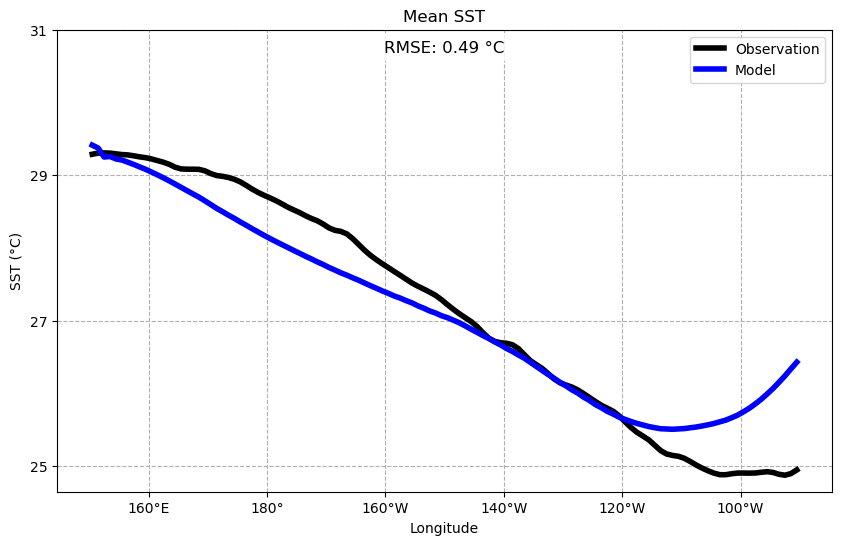

In [73]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["HadISST"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SST (°C)')
plt.title('Mean SST')
plt.grid(linestyle='--')
plt.yticks(np.arange(25,32, step=2))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the sea surface temperature (SST) structure across the equatorial Pacific (averaged between 5°S–5°N), primarily illustrating the cold tongue bias (typically warmer near South America and cooler further west). The black curve represents the reference data, while the blue curve represents the model data. The metric displayed is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


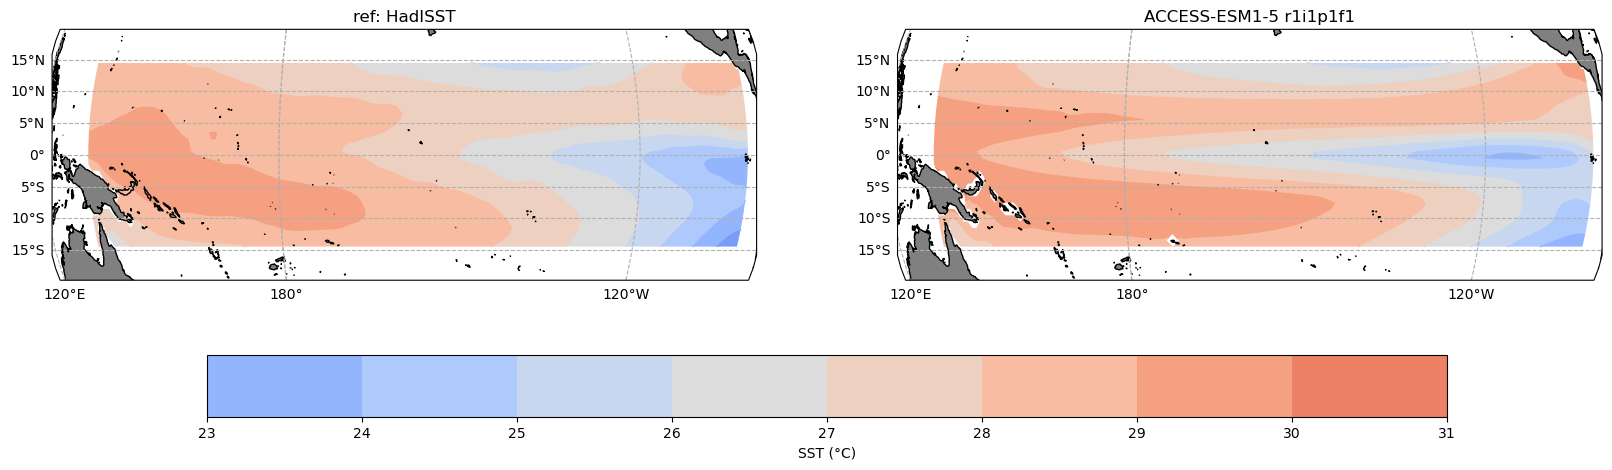

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["HadISST"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of 20 to 33°C
norm = mcolors.Normalize(vmin=20, vmax=33)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: HadISST")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')
#cbar.set_ticks(np.arange(20, 33))  # Set ticks at intervals of 2 degrees

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Time-mean sea surface temperature (SST) bias in the equatorial Pacific, primarily highlighting the cold tongue bias (warmer near South America and cooler further west). The left map displays the reference data, and the right map shows the model data.

In [83]:
import sys
sys.path.append("/g/data/tm70/yz9299/ARE/ACCESS-ENSO-recipes")
from visualization_tools.visualization import Visualization

<module 'visualization_tools.visualization' from '/g/data/tm70/yz9299/ARE/ACCESS-ENSO-recipes/visualization_tools/visualization.py'>

In [84]:
obs_data = obs_datasets_prep2["HadISST"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

v_model = Visualization(data=model_data, size=(150,600), lat_range=(-15, 15), lon_range=(150, 270), title="ACCESS-ESM1-5", colormap=plt.get_cmap('coolwarm'), tickvalues=[22,24,25,26,27,28,29,30,32], vmax=33, vmin=20)
v_obs = Visualization(data=obs_data, size=(150,600), lat_range=(-15, 15), lon_range=(150, 270), title="HadISST", colormap=plt.get_cmap('coolwarm'), tickvalues=[22,24,25,26,27,28,29,30,32], vmax=33, vmin=20)


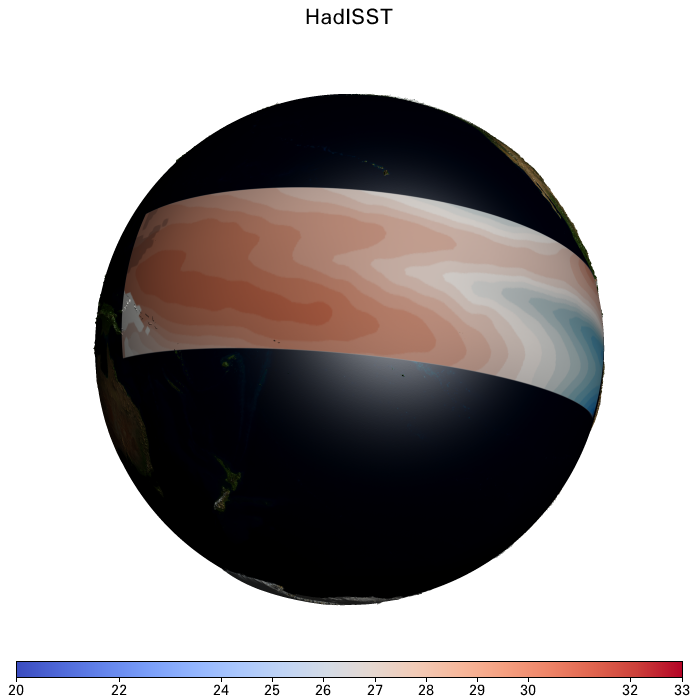

In [85]:
# specify window=True if you would like an interactive window
v_obs.visualise_contourf()


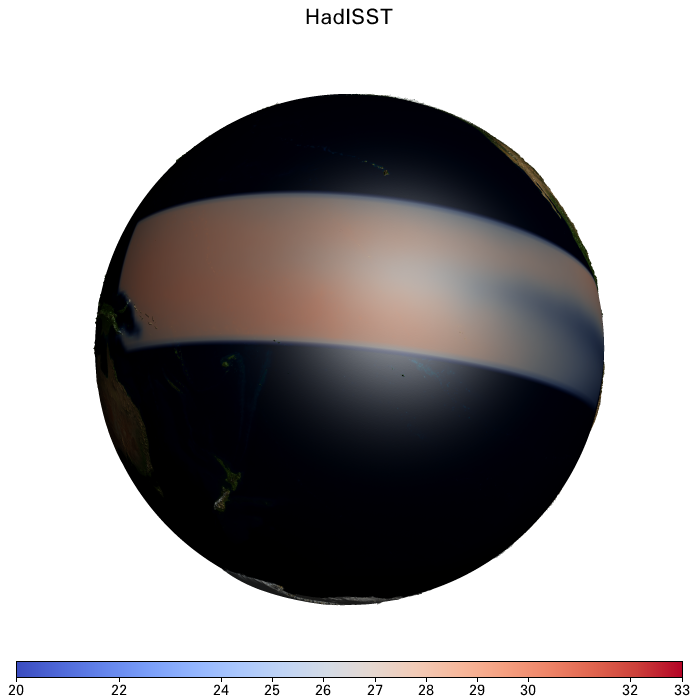

In [86]:
# specify window=True if you would like an interactive window
v_obs.visualise_gradient()


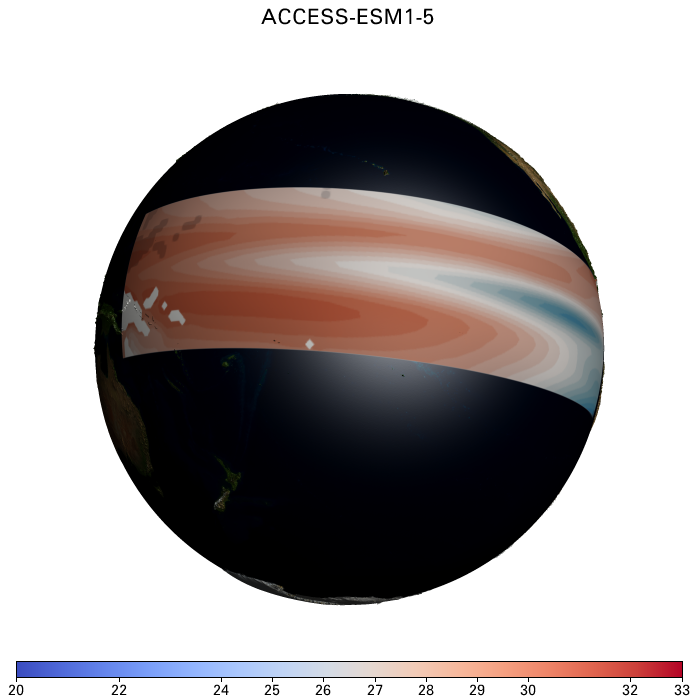

In [87]:
# specify window=True if you would like an interactive window
v_model.visualise_contourf()


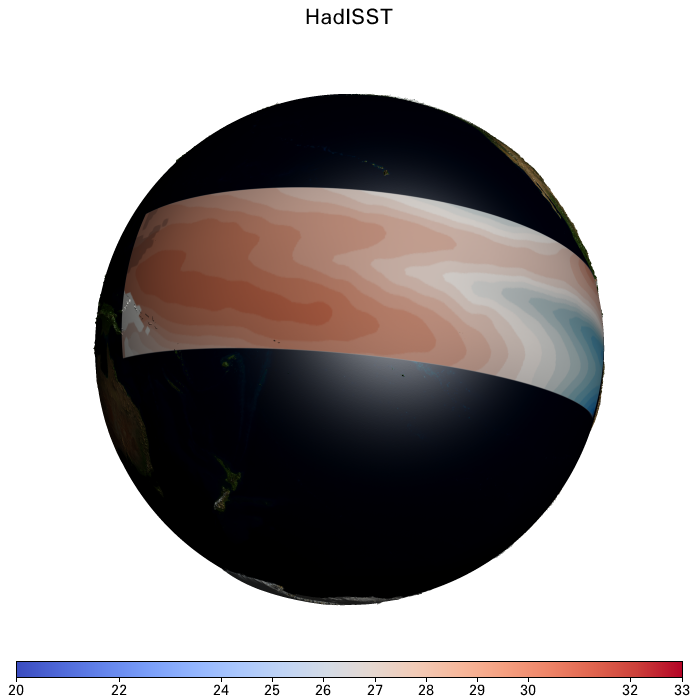

In [88]:
# specify window=True if you would like an interactive window
v_obs.visualise_contourf()